# Marginalized model

This notebook formulates a PyMC3 model for the fuzzy memory pool model and defines a new `MixtureSameFamily` distribution to marginalize all combinations of $M_b$ and $M_{max}$.

It has 3 main parts:

1. The game state representation
2. The function that computes the action probability for a game state and some latent parameter values
3. The mixture distribution that marginalizes all the combinations of the discrete variables away from the model

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
import theano
from theano import tensor as tt
import pymc3 as pm
from matplotlib import pyplot as plt
import arviz as az

## 1. Game state representation

We use the compact game state representation introduced in the data structure notebook

In [2]:
# We first get the possible combinations of S, D and W
states = []
all_S = [4, 6, 8, 10, 12]
all_D = list(range(max(all_S)))
all_W = list(range(max(all_D) + 1))
for S_code, S in enumerate(all_S):
    for D in range(S):
        for W in range(D + 1):
            states.append((S_code, D, W))
index = pd.MultiIndex(
    levels=[
        all_S,
        all_D,
        all_W,
    ],
    codes=list(zip(*states)),
    names=["S", "D", "W"],
    verify_integrity=True
)
index

MultiIndex([( 4,  0,  0),
            ( 4,  1,  0),
            ( 4,  1,  1),
            ( 4,  2,  0),
            ( 4,  2,  1),
            ( 4,  2,  2),
            ( 4,  3,  0),
            ( 4,  3,  1),
            ( 4,  3,  2),
            ( 4,  3,  3),
            ...
            (12, 11,  2),
            (12, 11,  3),
            (12, 11,  4),
            (12, 11,  5),
            (12, 11,  6),
            (12, 11,  7),
            (12, 11,  8),
            (12, 11,  9),
            (12, 11, 10),
            (12, 11, 11)],
           names=['S', 'D', 'W'], length=200)

In [3]:
S = index.get_level_values("S").to_numpy()
D = index.get_level_values("D").to_numpy()
W = index.get_level_values("W").to_numpy()

We compute all combinations for $M_b + M_{Max} <= 12$ that need to be marginalized away.

In [4]:
Ms = []
for Mb in range(12 + 1):
    for M_max in range(12 + 1 - Mb):
        Ms.append((Mb, M_max))
Ms = np.array(Ms)
Ms

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 3,  0],
       [ 3,  1],
       [ 3,  2],
       [ 3,  3],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  7],
       [ 3,  8],
       [ 3,  9],
       [ 4,  0],
       [ 4,  1],
       [ 4,  2],
       [ 4,  3],
       [ 4,  4],
       [ 4,  5],
       [ 4,  6],
       [ 4,  7],
       [ 4,  8],
       [ 5,  0],
       [ 5,  1],
       [ 5,  2],
       [ 5,  3

## 2. Choice probability

We compute the probability of incurring in a Between or Within Search Error (BSE and WSE respectively), and the probability of choosing a novel location (a Hit). We do this for all the possible game states and discrete memory slots combinations. This formulation was introduced and tested in the vectorized fuzzy memory probabilities notebook.

In [5]:
def vectorized_theano_prob(Ms, eta, r, S, D, W):
    # Parameter axis preparation
    # 
    # To be able to use the vectorized function, we need all of our
    # parameters to have a consistent number of dimensions and broadcastable
    # pattern. There are two computational stages in the function
    # 
    # 1. Computing the probability of BSE without lapses
    # 2. Using the result from 1 add in the lapses and compute all
    #    the other probabilities.
    # 
    # Stage 1 involves parameters Ms and r, so we have to ensure that
    # they can broadcast properly, and each axis serves the desired purpose.
    # We will compute things for (sample_shape, S_axis, Mb_axis, Mf_axis) where:
    # 
    # - The last axis (Mf_axis) is used to hold the Mf values (refer to the
    #   fuzzy memory model for its definition). We must sum over this axis to
    #   get the final probability of BSE without lapses.
    # - The second to last axis (Mb_axis) will label the distinct combinations of Mb
    #   and M_max. This axis will be used in the Mixture class distribution.
    # - The third to last axis (S_axis) will label the distinct combinations of
    #   S, D and W, that will eventually correspond to different observations
    # - The other axis can potentially hold independent draws from the parameters
    #   (aka sample_shape)
    #
    # For our purposes, we wont distinguish between the sample_shape and S_axis axes,
    # and will only write down sample_shape
    #
    # Ms will enter with shape (Mb_axis, 2)
    # r will enter with shape (sample_shape)
    # S, D and W will enter with shape (sample_shape)
    # 
    # We will add axis to make them broadcastable to (sample_shape, Mb_axis, Mf_axis)
    #
    # Stage 2 involves the result from stage 1 and the eta parameter
    # 
    # The result from stage 1 will have shape (sample_shape, Mb_axis)
    # eta will enter with shape (sample_shape)
    # S, D and W will enter with shape (sample_shape, 1, 1) because of what we did in stage 1
    #
    # We will add an axis to eta, and remove the last axis from
    # S, D, W (and B = D - W) to make them broadcastable to (sample_shape, Mb_axis)
    
    Mb = Ms[:, 0, None]
    M_max = Ms[:, 1, None]
    r = r[..., None, None]
    eta = eta[..., None]
    S = S[..., None, None]
    D = D[..., None, None]
    W = W[..., None, None]
    B = D - W

    # Stage 1: we compute the probability of BSE without lapses
    M_used = np.minimum(np.maximum(0, B - Mb), M_max)
    # We create the Mf values that have shape (Mf_axis,)
    Mf = np.arange(np.max(S) + 1)
    # We compute the probability of each Mf value
    P_mf = pm.Binomial.dist(p=r, n=M_used).logp(Mf)

    # We compute the probability of BSE for every Mf, Mb, and M_max combination
    denom = S - Mb - Mf - W
    numer = tt.nnet.relu(B - Mb - Mf)
    P_bse_without_slips = tt.sum(
        tt.switch(
            tt.le(denom, 0),
            0,
            numer / denom * tt.exp(P_mf),
        ),
        axis=-1,  # We sum over all values of Mf
    )
    
    # Stage 2: compute all the choice probabilities
    # We first have to remove the Mf_axis from S, D, W and B
    S = S[..., 0]
    D = D[..., 0]
    W = W[..., 0]
    B = B[..., 0]
    
    P_bse = (1 - eta) * P_bse_without_slips + eta * B / S
    
    # The shape of P_bse is (sample_shape, Mb_axis)
    # The shape of eta is (sample_shape, 1)
    # We must ensure that all probabilities are returned with the
    # exact same shape, or we wont be able to use then in a Mixture
    # This means that we need to use tt.tile or tt.repeat
    P_wse = tt.repeat(eta * W / S, Mb.shape[-2], axis=-1)
    P_hit = 1 - P_wse - P_bse
    
    # We return the stack of P_hit, P_bse, P_wse in the last axis
    # This means our output tensor has shape (sample_shape, Mb_axis, 3)
    return tt.stack([P_hit, P_bse, P_wse], axis=-1)

## 3. The mixture distribution

From a generative process perspective, a mixture takes many different distributions, called the __component distributions__, and chooses from one with a probability that is determined by the __component weights__ `w`, then it draws random value from the chosen component distribution. The discrete label that identifies the chosen component is not inferred directly because it is marginalized out of the mixture's `logp`.

#### How do pymc3 mixtures work?

There are two ways in which you can specify the mixture components

1. Use a single `Distribution` instance with a batch shape. This means that you need a distribution with a `shape` that isn't a scalar. The existing `Mixture` then assumes that the __last dimension of the passed distribution represents the different components__. In our case, this is a fatal draw back because we __need to use a `Multinomial` for each component__, and a `Multinomial` distribution has an _`event_shape`_ that isn't a scalar (we use the naming convention introduced by TFP). That means that no matter how we try to stack or batch a `Multinomial` distribution, the last dimension will always represent the `event_shape`, and will never represent the mixture's components. For the particular problem we are studying here, the `event_shape` is `(3,)` and represents the different choices a subject can make in a given game state.
2. Use a list of `Distribution` instances. This methods allows us to pass in any kind of `Distribution` as the mixture component, and avoids all the problems around non-scalar event shapes. However, it has drawbacks. First, it is slower because it has to iterate over the list entries and can't do so in a vectorized manner. Second and most importantly, pymc3's built-in `Mixture` can only work with 32 components due to some limits regarding python's variable arguments expansion (`*args`).

#### What can we do?

We have to implement a new mixture distribution that takes a single `Distribution` instance with a batch shape, but where the users can also flexibly choose the axis that represents the mixture components. This will provide the nice properties of vectorized `logp` (and potentially also `random`) computations, and will also be usable with `Multinomial` mixture components (or any other multivariate distribution with an event shape that isn't scalar).

Based on this new distribution's functionality, we choose to call it `MixtureSameFamily` given that it is very similar to TFP's version.

In [6]:
from pymc3.math import logsumexp
from pymc3.theanof import take_along_axis
from pymc3.distributions.dist_math import bound
from pymc3.distributions.shape_utils import (
    broadcast_dist_samples_shape,
    to_tuple,
    get_broadcastable_dist_samples,
)


class MixtureSameFamily(pm.Distribution):
    def __init__(self, w, comp_dists, mixture_axis=-1, *args, **kwargs):
        self.w = tt.as_tensor_variable(w)
        if not isinstance(comp_dists, pm.Distribution):
            raise TypeError(
                "The MixtureSameFamily distribution only accepts Distribution "
                f"instances as its components. Got {type(comp_dists)} instead."
            )
        self.comp_dists = comp_dists
        if mixture_axis < 0:
            mixture_axis = len(comp_dists.shape) + mixture_axis
        comp_shape = to_tuple(comp_dists.shape)
        self.shape = comp_shape[:mixture_axis] + comp_shape[mixture_axis + 1:]
        self.mixture_axis = mixture_axis
        kwargs.setdefault("dtype", self.comp_dists.dtype)
        
        # Computvalte the mode so we don't always have to pass a tes
        defaults = kwargs.pop("defaults", [])
        event_shape = self.comp_dists.shape[mixture_axis + 1:]
        _w = tt.shape_padleft(
            tt.shape_padright(w, len(event_shape)),
            len(self.comp_dists.shape) - w.ndim - len(event_shape),
        )
        mode = take_along_axis(
            self.comp_dists.mode,
            tt.argmax(_w, keepdims=True),
            axis=mixture_axis,
        )
        self.mode = mode[(..., 0) + (slice(None),) * len(event_shape)]
        defaults.append("mode")
        
        super().__init__(defaults=defaults, *args, **kwargs)

    def logp(self, value):
        """
        Calculate log-probability of defined ``MixtureSameFamily`` distribution at specified value.

        Parameters
        ----------
        value : numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor

        Returns
        -------
        TensorVariable
        """
        # self.w.shape (batch_shape, mixture_axis)
        # self.comp_dists.shape (batch_shape, mixture_axis, event_shape)
        # value.shape (batch_shape, event_shape)
        
        comp_dists = self.comp_dists
        w = self.w
        mixture_axis = self.mixture_axis
        
        event_shape = comp_dists.shape[mixture_axis + 1:]
        
        # To be able to broadcast the comp_dists.logp with w and value
        # We first have to pad the shape of w to the right with ones
        # so that it can broadcast with the event_shape.
        
        w = tt.shape_padright(w, len(event_shape))
        
        # Second, we have to add the mixture_axis to the value tensor
        # To insert the mixture axis at the correct location, we use the
        # negative number index. This way, we can also handle situations
        # in which, value is an observed value with more batch dimensions
        # than the ones present in the comp_dists
        comp_dists_ndim = len(comp_dists.shape)
        
        value = tt.shape_padaxis(value, axis=mixture_axis - comp_dists_ndim)
        
        comp_logp = comp_dists.logp(value)
        
        return bound(
            logsumexp(tt.log(w) + comp_logp, axis=mixture_axis, keepdims=False),
            w >= 0,
            w <= 1,
            tt.allclose(w.sum(axis=mixture_axis - comp_dists_ndim), 1),
            broadcast_conditions=False,
        )
    
    def random(self, point=None, size=None):
        """
        Draw random values from defined ``MixtureSameFamily`` distribution.

        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).

        Returns
        -------
        array
        """
        sample_shape = to_tuple(size)
        mixture_axis = self.mixture_axis
        
        # First we draw values for the mixture component weights
        w, = pm.distributions.distribution.draw_values(
            [self.w], point=point, size=size
        )
        
        # We now draw do random choices from those weights
        # However, we have to ensure that the number of choices has the
        # sample_shape prepent
        choice_shape = (
            w.shape[:-1]
            if w.shape[:len(sample_shape)] == sample_shape            
            else sample_shape + w.shape[:-1]
        )
        choices = pm.distributions.dist_math.random_choice(p=w, size=choice_shape)
        
        # We now draw samples from the mixture components random method
        comp_samples = self.comp_dists.random(point=point, size=size)
        if comp_samples.shape[:len(sample_shape)] != sample_shape:
            comp_samples = np.broadcast_to(
                comp_samples,
                shape=sample_shape + comp_samples.shape,
            )
        
        # At this point the shapes of the arrays involved are:
        # comp_samples.shape = (sample_shape, batch_shape, mixture_axis, event_shape)
        # choices.shape = (sample_shape, batch_shape)
        #
        # To be able to take the choices along the mixture_axis of the
        # comp_samples, we have to add in dimensions to the right the
        # choices array
        # We also need to make sure that the batch_shapes of both the comp_samples
        # and choices broadcast with each other
        
        event_shape = comp_dists.shape[mixture_axis + 1:]
        
        choices = np.reshape(choices, choices.shape + (1,) * (1 + len(event_shape)))
        
        choices, comp_samples = get_broadcastable_dist_samples(
            [choices, comp_samples], size=size
        )
        
        # We now take the choices of the mixture components along the mixture_axis
        # but we use the negative index representation to be able to handle the
        # sample_shape
        samples = np.take_along_axis(
            comp_samples, choices, axis=mixture_axis - len(comp_dists.shape)
        )
        
        # The samples array still has the mixture_axis, so we must remove it
        output = samples[(..., 0) + (slice(None),) * len(event_shape)]
        
        # Final oddity: if size == 1, pymc3 defaults to reducing the sample_shape dimension
        # We do this to stay consistent with the rest of the package even though
        # we shouldn't have to do it.
        if size == 1:
            output = output[0]
        return output

In [7]:
n = 100 * np.ones((len(S), 1))

with pm.Model() as marginalized_model:
    eta = pm.Beta("eta", alpha=1, beta=10)
    r = pm.Beta("r", alpha=7, beta=3)
    w = np.ones(len(Ms)) / len(Ms)
    comp_dists = pm.Multinomial.dist(
        p=vectorized_theano_prob(Ms=Ms, eta=eta, r=r, S=S, D=D, W=W),
        n=n,
        shape=(len(S), len(Ms), 3)
    )
    observed = MixtureSameFamily(
        "observed",
        w=w,
        comp_dists=comp_dists,
        mixture_axis=1,
        shape=(len(S), 3),
    )
    prior = pm.sample_prior_predictive(samples=1)

In [8]:
{k: v if v.ndim == 0 else v.shape for k, v in prior.items()}

{'eta': array(0.04557559),
 'observed': (200, 3),
 'r_logodds__': 1.653409565200394,
 'eta_logodds__': -3.0417362838428867,
 'r': array(0.83935133)}

In [9]:
marginalized_model.logp(prior)

array(-603.14709485)

-----

# Model inference

Now that we have our working marginalized model, we are interested in checking whether we can generate samples from the model's prior, and then run our inference and recover the latent variables

In [10]:
def factory(S, D, W, Ms, n, observed=None, **kwargs):
    with pm.Model(**kwargs) as model:
        eta = pm.Beta("eta", alpha=1, beta=10)
        r = pm.Beta("r", alpha=7, beta=3)
        w = np.ones(len(Ms)) / len(Ms)
        comp_dists = pm.Multinomial.dist(
            p=vectorized_theano_prob(Ms=Ms, eta=eta, r=r, S=S, D=D, W=W),
            n=n,
            shape=(len(S), len(Ms), 3), # Some strange bug with dims -> shape transformation in __init__ makes us do this
            dims=["game_state", "mixture_component", "action"],
        )
        comp_dists.name = "MixtureComponents"
        MixtureSameFamily(
            "observed",
            w=w,
            comp_dists=comp_dists,
            mixture_axis=1,
            dims=["game_state", "action"],
            observed=observed,
        )
    return model

In [11]:
n = 1000 * np.ones((len(S), 1))

coords = {
    "game_state": range(len(S)),
    "mixture_component": range(len(Ms)),
    "action": ["Hit", "BSE", "WSE"],
}

np.random.seed(47)

with factory(S, D, W, Ms, n, coords=coords) as model:
    prior = pm.sample_prior_predictive(100)

In [12]:
{k: v.shape for k, v in prior.items()}

{'eta': (100,),
 'observed': (100, 200, 3),
 'r_logodds__': (100,),
 'eta_logodds__': (100,),
 'r': (100,)}

In [13]:
from matplotlib import pyplot as plt


def plotter(S, D, W, observed, jitter=0.05, **kwargs):
    MAX_W = np.max(W)
    uS = np.unique(S)
    fig, axs = plt.subplots(len(uS), 3, sharex="row", sharey="row", **kwargs)
    for row, s in enumerate(uS):
        inds = S == s
        d = D[inds]
        w = W[inds]
        obs = observed[..., inds, :]
        for col, (data, title) in enumerate(zip(np.moveaxis(obs, -1, 0), ["Hit", "BSE", "WSE"])):
            ax = axs[row, col]
            x, y, c = np.broadcast_arrays(d, data, w / MAX_W)
            alpha = np.minimum(1, 10 / np.prod(data.shape[:-1]))
            ax.scatter(x + jitter * np.random.randn(*x.shape), y, c=c, alpha=alpha, vmax=1, vmin=0)
            if row == 0:
                ax.set_title(title)
            if col == 0:
                ax.set_ylabel(f"Observation S = {s}")
            if row == (len(uS) - 1):
                ax.set_xlabel("D")
    fig.tight_layout()
    return fig

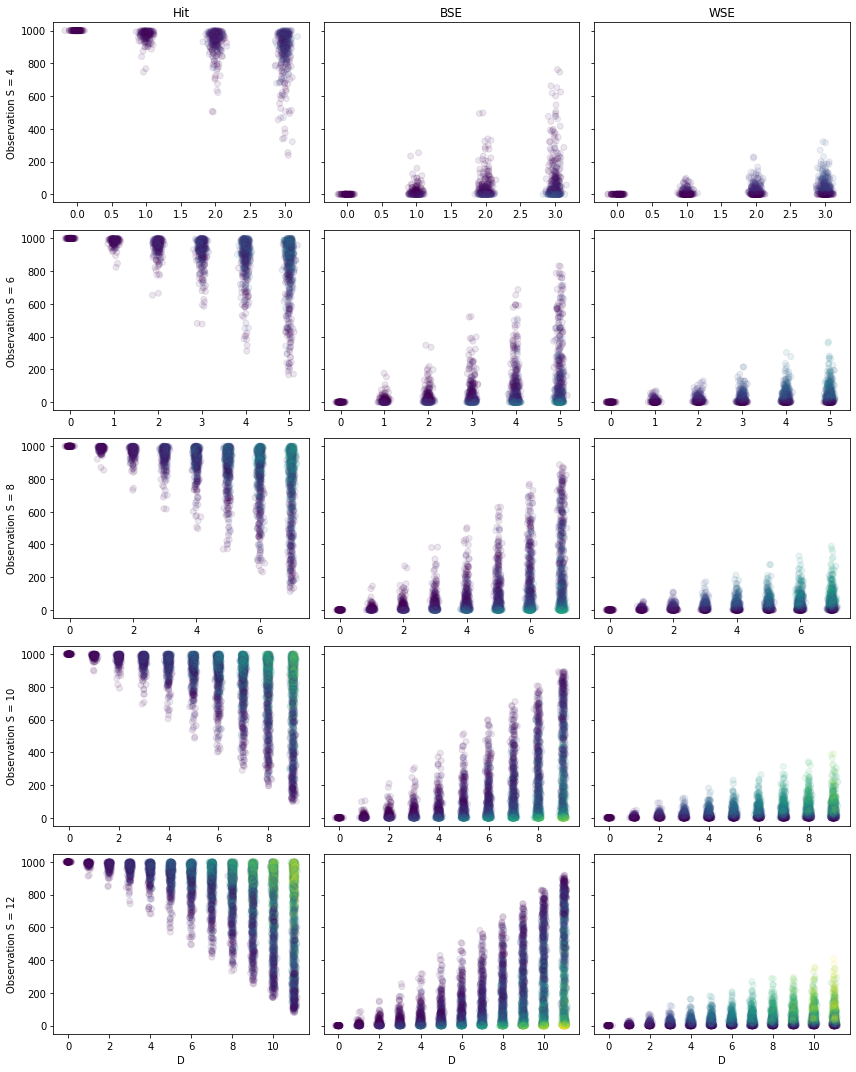

In [14]:
plotter(S, D, W, prior["observed"], figsize=(12, 15));

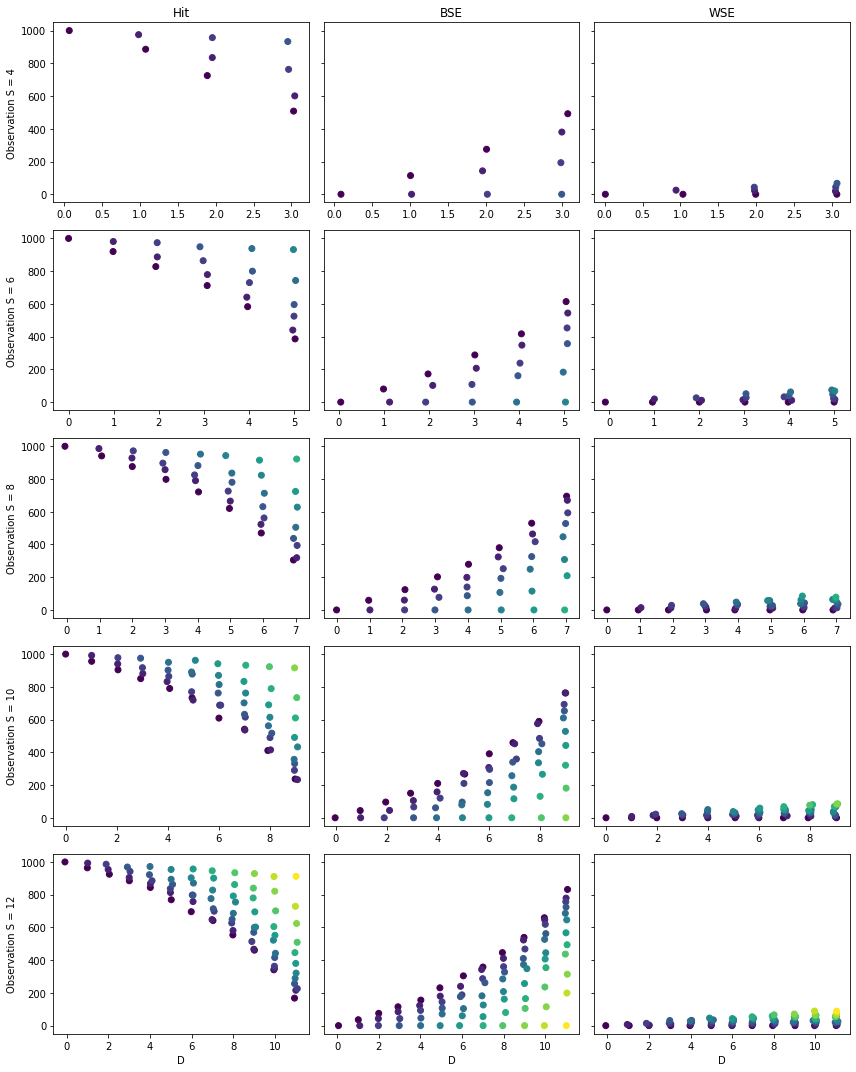

In [15]:
plotter(S, D, W, prior["observed"][0], figsize=(12, 15));

In [16]:
with factory(S, D, W, Ms, n, observed=prior["observed"][0], coords=coords) as model:
    trace = pm.sample(return_inferencedata=False, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 88 seconds.


In [17]:
trace

<MultiTrace: 2 chains, 1000 iterations, 4 variables>

In [18]:
{k: v[0] for k, v in prior.items() if k != "observed"}

{'eta': 0.09234408185646319,
 'r_logodds__': 0.3977327580603316,
 'eta_logodds__': -2.28534374126583,
 'r': 0.5981428091969065}

In [19]:
az.plot_trace(trace)

/home/lpaz/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/lpaz/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:93: UserWarning: In variable observed, there are more dims (2) given than exist (1). Passed array should have shape (chain,draw, *shape)
  UserWarning,
/home/lpaz/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


ValueError: different number of dimensions on data and dims: 3 vs 4